Accuracy: 0.21125417745399486
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.78      0.28     97278
           1       0.57      0.07      0.13    396743

    accuracy                           0.21    494021
   macro avg       0.37      0.43      0.20    494021
weighted avg       0.49      0.21      0.16    494021



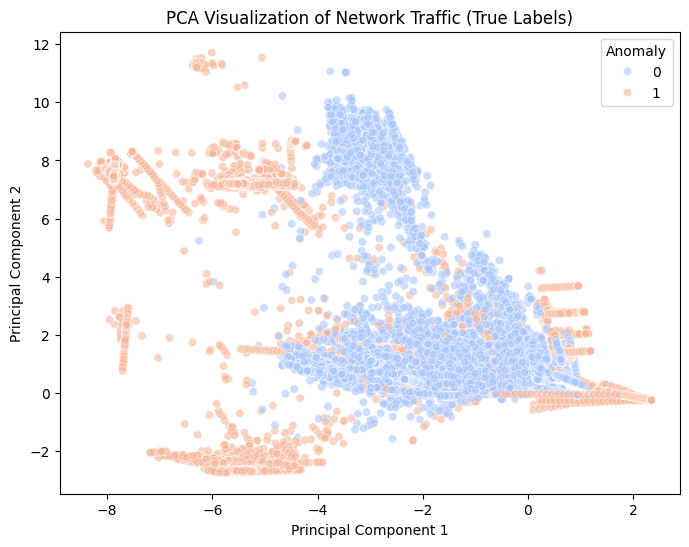

In [2]:
# ----------------------------------------
#  Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

# ----------------------------------------
# Load the KDD Cup 1999 dataset (10% sample)
dataset_url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"

# Define column names (only partial given in original file, here's the complete list shortened for simplicity)
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", 
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
data = pd.read_csv(dataset_url, names=columns, compression='gzip')

# ----------------------------------------
# Encode categorical features to numeric
categorical_features = ["protocol_type", "service", "flag"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# ----------------------------------------
#  Convert labels to binary (normal = 0, anomaly = 1)
data['label'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# ----------------------------------------
# Normalize features
X = data.drop(columns=['label'])
y = data['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------------
# Reduce dimensionality with PCA (keep 10 principal components)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# ----------------------------------------
#  Anomaly detection using Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_pca)
y_pred = model.predict(X_pca)

# Convert IsolationForest output: 1 = normal, -1 = anomaly → to match label format: 0 = normal, 1 = anomaly
y_pred = np.where(y_pred == 1, 0, 1)

# ----------------------------------------
# Evaluate the model
print("Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

# ----------------------------------------
#  Visualize the PCA-reduced feature space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Network Traffic (True Labels)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Anomaly")
plt.show()
